## Settings

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import shutil
from pathlib import Path
import sys
import datetime as dt
import matplotlib.pyplot as plt
import cosmicsense as cs

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sddir = "/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/sd"
remotedir = "/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/remote"
#remotetrgdir = "/media/x/cosmicsense/data/marquardt/crns_merged/remote"
remotetrgdir = "/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/remote/merged-from-2023"
#sdtrgdir = "/media/x/cosmicsense/data/marquardt/crns_merged/sd"
sdtrgdir = "/media/x/cosmicsense/data/marquardt/crns_merged/sd"
#bothtrgdir = "/media/x/cosmicsense/data/marquardt/crns_merged/both"
bothtrgdir = "/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/merged"
#remotefilesreport = "/media/x/cosmicsense/data/marquardt/crns_merged/remote_files_report2.csv"
remotefilesreport = "/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/remote/merged-from-2023/remote_files_merge_report.csv"
#sdfilesreport = "/media/x/cosmicsense/data/marquardt/crns_from_sd/sd_files_report2.csv"
sdfilesreport = "/media/x/cosmicsense/data/marquardt/crns_from_sd/sd_files_report.csv"
tmpfile = "tmpfile.txt"
#ids = [1, 2, 4, 21, 22, 26, 27, 28]
ids = [1, 4, 11, 21, 22, 26, 27, 33, 34, 35]
styxids = [12,31,36,38]
finappids = [32]
canbids = [2]

In [4]:
crns = {
      1: {"remotepattern": "up1_Data*.001*.txt",
          "remoteblacklist": [],
          "sdpattern": "*.001",
          "sdblacklist": []
         },

#       2: {"remotepattern": "up2_Data*.002*.txt",
#           "remoteblacklist": [],
#           "sdpattern": "*.002",
#           "sdblacklist": []
#          },

      4: {"remotepattern": "up4_Data*.004*.txt",
          "remoteblacklist": [],
          "sdpattern": "*.004",
          "sdblacklist": []
         },
    
      11: {"remotepattern": "c-4_Data_*.lc4_*.txt",
          "remoteblacklist": [],
          "sdpattern": "*.lc4",
          "sdblacklist": []
         },

     21: {"remotepattern": "CRSProbe_Data*.021*.txt",
          "remoteblacklist": [],
           "sdpattern": "*.021",
          "sdblacklist": []
         },

     22: {"remotepattern": "CRSProbe_Data*.022*.txt",
          "remoteblacklist": [],
          "sdpattern": "*.022",
          "sdblacklist": []
         },

     26: {"remotepattern": "up26_Data*.026*.txt",
          "remoteblacklist": [],
          "sdpattern": "*.026",
          "sdblacklist": []
         },

     27: {"remotepattern": "up27_Data*.027*.txt",
          "remoteblacklist": [],
          "sdpattern": "*.027",
          "sdblacklist": ["2005201211.027", "2005201218.027"]
         },

     28: {"remotepattern": "sonde28_Data_*.028*",
          "remoteblacklist": [],
          "sdpattern": "*.028",
          "sdblacklist": []
         },

     33: {"remotepattern": "mq_33_Data_*.txt",
          "remoteblacklist": [],
          "sdpattern": "*.033",
          "sdblacklist": []
         },

     34: {"remotepattern": "mq_34_Data_*.txt",
          "remoteblacklist": [],
          "sdpattern": "*.034",
          "sdblacklist": ["2209291111.034"]
         },

     35: {"remotepattern": "mq_35_Data_*.txt",
          "remoteblacklist": [],
          "sdpattern": "*.035",
          "sdblacklist": []
         }

}

## Read remote data

In [5]:
# We have written down all the expected setups in this csv file
setup = pd.read_csv("/media/x/cosmicsense/git/cosmicsense-notebooks/notebooks/mq/mq_sensor_setups_from_2023.csv", sep="\t")
setup["names2"] = [eval(setup.loc[i,"names"]) for i in range(len(setup))]

In [6]:
# Create overall structure as per sensor
for id in ids:
    crns[id]["remotedata"] = pd.DataFrame(columns = setup.loc[setup.id==id, "names2"].to_list()[0])
    
report = pd.DataFrame(columns=["id", "file", "rows", "toomany", "notenough", "corruptstamp"])

# Find all column changes FROM FILE
for i, id in enumerate(ids):
    print("-------------")
    print("Processing %d" % id)

    # REMOTE FILES
    print("   Remote: ", end="")
    if id==11:
        searchdir = os.path.join(remotedir,"c-4", crns[id]["remotepattern"])
    else:
        searchdir = os.path.join(remotedir,"%d" % id, crns[id]["remotepattern"])
    remotefiles = sorted(glob.glob(searchdir, recursive=True))
    print("found %d files" % len(remotefiles))#, end="")
        
    current_sensor = setup.loc[setup.id==id]
    df = crns[id]["remotedata"]
    
    startrecording = False

    for name in remotefiles:
        # Check if we reached the first file from which we want to start recording data
        if not startrecording:
            startrecording = current_sensor.firstremote.to_list()[0] == os.path.basename(name)
        if not startrecording:
            continue
#         else:
#             print(os.path.basename(name))
            
        cols = current_sensor.names2.tolist()[0]
            
        with open(name, 'r') as fin:
            lines = fin.readlines()
            fin.close()
        # We perform our own line sanity before using pandas
        # and write it to tmpfile
        with open(tmpfile, 'w') as fout:
            nrows = 0
            ntoomany = 0
            nnotenough = 0
            ncorruptstamp = 0
            for line in lines:
                line = line.strip()
                if "//" in line:
                    continue
                if len(line) == 0:
                    continue
                nrows += 1
                # remove trailing comma
                line = line.strip(",")
                nexpect = len(cols) - 1
                if line.count(",") == nexpect:
                    # Check for corrupt time stamps
                    try:
                        _ = dt.datetime.strptime(line.split(",")[1].strip(), "%Y/%m/%d %H:%M:%S")
                    except ValueError:
                        ncorruptstamp += 1
                        continue
                    fout.write(line+"\n")
                elif line.count(",") > nexpect:
                    ntoomany += 1
                else:
                    nnotenough += 1
        report.loc[len(report)] = [id, os.path.basename(name), nrows, ntoomany, nnotenough, ncorruptstamp]
        # Read again as Pandas dataframe
        try:
            df1 = pd.read_csv(tmpfile, sep=",", comment="#", header=None, names=cols)
        except pd.errors.EmptyDataError:
            continue
        df = df.append(df1, ignore_index=True)
           
    df.datetime = pd.to_datetime(df.datetime, format="%Y/%m/%d %H:%M:%S")
    df = df.set_index("datetime")
    df.insert(loc=1, column="datetime", value=df.index)
    df = df.sort_index()
#    df = df[df.index >= "2019-07-25"]
    dupl = df.index.duplicated(keep='first')
    if np.any(dupl):
        print("Contains %d duplicates" % len(np.where(dupl)[0]))
        df = df[~dupl]    
    fpath = os.path.join(remotetrgdir, "%d_CRNS.txt" % id )
    df.to_csv(fpath, sep="\t", index=False, date_format="%Y-%m-%d %H:%M:%S", na_rep="na")
    crns[id]["remotedata"] = df
report.to_csv(remotefilesreport, sep=";", index=False, na_rep="na")

-------------
Processing 1
   Remote: found 4946 files
-------------
Processing 4
   Remote: found 5213 files
-------------
Processing 11
   Remote: found 3182 files
-------------
Processing 21
   Remote: found 5667 files
-------------
Processing 22
   Remote: found 5504 files
-------------
Processing 26
   Remote: found 6081 files
-------------
Processing 27
   Remote: found 1770 files
-------------
Processing 33
   Remote: found 601 files
-------------
Processing 34
   Remote: found 857 files
-------------
Processing 35
   Remote: found 731 files


In [7]:
# Finapp
columns = "datetime", "counts1", "muons", "gamma", "nsecs1", "volt", "temp1", "temp_ext", "relhum1", "press1"
# Neutron probe
fa_neutron = pd.read_csv("http://www.finapptech.com/finapp/api/getCSV_id.php?ID=34&D=1", sep=";")
fa_neutron.columns = columns
fa_neutron = fa_neutron.drop_duplicates(subset="datetime")
fa_neutron = fa_neutron.set_index(pd.to_datetime(fa_neutron["datetime"])).sort_index()
fpath = os.path.join(remotetrgdir, "32_CRNS.txt")
fa_neutron.to_csv(fpath, sep="\t", index=False, date_format="%Y-%m-%d %H:%M:%S", na_rep="na")

## Collect data from SD from network share

First, you need to mount network shares from etc/fstab via sudo mount -a. 

In [8]:
# Check
fielddir = "/media/geoecology-projekte/CRS/Marquardt/field"
os.path.exists(fielddir)

True

In [9]:
copy_sd_to = "/media/x/cosmicsense/data/marquardt/crns_from_sd"

**Attention**: The number of found files does not correspond to the number of files in the target directory because of many duplicate files in the source directory. As far as I can see, the duplicate files have the same content, they just have been repeatedly downloaded from the logger on different dates.

In [10]:
for i, id in enumerate(ids):
    print("-------------")
    print("Processing %d" % id)

    # SD FILES
    print("   SD: ", end="")
    searchdir = os.path.join(fielddir, "**", crns[id]["sdpattern"])
    sdfiles = glob.glob(searchdir, recursive=True)
    print("found %d files" % len(sdfiles))#, end="")
    for sdfile in sdfiles:
        if "pr2" in sdfile:
            continue
        dirname = os.path.dirname(sdfile)
        fname = os.path.basename(sdfile)
        trgdir = os.path.join(copy_sd_to, "%d" % id)
        if dirname[-3:] == "alt":
            try:
                os.mkdir(os.path.join(copy_sd_to, "%d" % id, "alt"))
            except FileExistsError:
                pass
            trgdir = os.path.join(trgdir, "alt")
        shutil.copyfile(sdfile, os.path.join(trgdir, fname))

-------------
Processing 1
   SD: found 281 files
-------------
Processing 4
   SD: found 112 files
-------------
Processing 11
   SD: found 40 files
-------------
Processing 21
   SD: found 207 files
-------------
Processing 22
   SD: found 278 files
-------------
Processing 26
   SD: found 222 files
-------------
Processing 27
   SD: found 6248 files
-------------
Processing 33
   SD: found 21 files
-------------
Processing 34
   SD: found 65 files
-------------
Processing 35
   SD: found 5 files


## Read data from SD

In [11]:
sdreport = pd.DataFrame(columns=["id", "file", "rows", "toomany", "notenough", "nnoheader", "nnodecode"])

# Create overall structure as per sensor
for id in ids:
    crns[id]["sddata"] = pd.DataFrame(columns = setup.loc[setup.id==id, "names2"].to_list()[0])

# Find all column changes FROM FILE
for k, id in enumerate(ids):
    print("-------------")
    print("Processing %d" % id)

    # SD FILES
    print("   SD: ", end="")
    searchdir = os.path.join(copy_sd_to,"%d" % id, crns[id]["sdpattern"])
    files = sorted(glob.glob(searchdir))#, recursive=True))
    print("found %d files" % len(files))#, end="")
          
    current_sensor = setup.loc[setup.id==id]
    df = crns[id]["sddata"]
    
    startrecording = False
    
    
    for name in files:
        # Check if we reached the first file from which we want to start recording data
        if not startrecording:
            startrecording = current_sensor.firstsd.to_list()[0] == os.path.basename(name)
        if not startrecording:
            continue
            
        cols = current_sensor.names2.tolist()[0]

        # Check for files that are spurious, corrupt, or irrelevant
        ym = os.path.basename(name)[0:4] 
        if (ym == "1007") or (ym == "3709"):
            # These are old or corrupt files we're not interested in
            continue
        if os.path.basename(name) in crns[id]["sdblacklist"]:
            continue
        if len(os.path.basename(name).split(".")[0])>8 and id==27:
            continue
            
#        print (os.path.basename(name))
        with open(name, 'r') as fin:
            try:
                lines = fin.readlines()
            except UnicodeDecodeError:
                fin.close()
                print("SKIP FILE: Cannot decode file %s" % name)
                sdreport.loc[len(sdreport)] = [id, os.path.basename(name), -99, -99, -99, -99, 1]
                continue
            fin.close()
        
        if not id==27:
            with open(tmpfile, 'w') as fout:
                nrows = 0
                ntoomany = 0
                nnotenough = 0
                ncorruptstamp = 0
                for line in lines:
                    line = line.strip()
                    if "//" in line:
                        continue
                    if len(line) == 0:
                        continue
                    if line[:3]=="CRS":
                        continue
                    nrows += 1
                    # remove trailing comma
                    line = line.strip(",")
                    nexpect = len(cols) - 1
                    if line.count(",") == nexpect:
                        # Check for corrupt time stamps
                        try:
                            _ = dt.datetime.strptime(line.split(",")[1].strip(), "%Y/%m/%d %H:%M:%S")
                        except ValueError:
                            ncorruptstamp += 1
                            continue
                        fout.write(line+"\n")
                    elif line.count(",") > nexpect:
                        ntoomany += 1
                    else:
                        nnotenough += 1
                    # Read again as Pandas dataframe
#             try:
#                 df1 = pd.read_csv(tmpfile, sep=",", comment="#", header=None, names=cols)
#             except pd.errors.EmptyDataError:
#                 continue
        else:
            with open(name, 'r') as fin:
                tmp = fin.readlines()
            if "1.363CRNS_BF3" in tmp[0]:
#                 df1=pd.read_csv(name,sep="\t",comment="#", header=None, 
#                                 names=["datetime","dummy","counts1","nsecs1",
#                                        "rec_id","weissnich1","weissnich2","weissnich3",
#                                        "weissnich4"],
#                                error_bad_lines=False)
#                 print(df1.shape[1])
                print(name)
                with open(tmpfile, 'w') as fout:
#                    fout.write("datetime,dummy,counts1,nsecs1,rec_id,weissnich1,weissnich2,weissnich3,weissnich4\n")
                    for i in range(1,len(tmp)):
                        line = tmp[i].replace("\t", ",")
                        if line.count(",") == (9 - 1):
                            fout.write(line)
                        else:
                            continue
            
        sdreport.loc[len(sdreport)] = [id, os.path.basename(name), nrows, ntoomany, nnotenough, 0, 0]
    
#         # Read again as Pandas dataframe
        try:
            df1 = pd.read_csv(tmpfile, sep=",", comment="#", header=None, names=cols)
        except pd.errors.EmptyDataError:
            continue
        df = df.append(df1, ignore_index=True)
           
    df.datetime = pd.to_datetime(df.datetime, format="%Y/%m/%d %H:%M:%S")
    df = df.set_index("datetime")
    df.insert(loc=1, column="datetime", value=df.index)
    df = df.sort_index()
#    df = df[df.index >= "2019-07-25"]
    dupl = df.index.duplicated(keep='first')
    if np.any(dupl):
        print("Contains %d duplicates" % len(np.where(dupl)[0]))
        df = df[~dupl]    
    fpath = os.path.join(remotetrgdir, "%d_CRNS.txt" % id )
#    df.to_csv(fpath, sep="\t", index=False, date_format="%Y-%m-%d %H:%M:%S", na_rep="na")
    crns[id]["sddata"] = df

    
sdreport.to_csv(sdfilesreport, sep=";", index=False, na_rep="na")
    
#     crns[id]["sddata"] = df



-------------
Processing 1
   SD: found 127 files
-------------
Processing 4
   SD: found 103 files
-------------
Processing 11
   SD: found 40 files
-------------
Processing 21
   SD: found 58 files
-------------
Processing 22
   SD: found 94 files
-------------
Processing 26
   SD: found 116 files
-------------
Processing 27
   SD: found 2095 files
/media/x/cosmicsense/data/marquardt/crns_from_sd/27/20221011.027
/media/x/cosmicsense/data/marquardt/crns_from_sd/27/20221115.027
/media/x/cosmicsense/data/marquardt/crns_from_sd/27/20221124.027
/media/x/cosmicsense/data/marquardt/crns_from_sd/27/20221130.027
/media/x/cosmicsense/data/marquardt/crns_from_sd/27/20221220.027
/media/x/cosmicsense/data/marquardt/crns_from_sd/27/20230113.027
/media/x/cosmicsense/data/marquardt/crns_from_sd/27/20230214.027
/media/x/cosmicsense/data/marquardt/crns_from_sd/27/20230308.027
/media/x/cosmicsense/data/marquardt/crns_from_sd/27/20230328.027
/media/x/cosmicsense/data/marquardt/crns_from_sd/27/20230404.0

In [12]:
df.shape

(3019, 17)

## Merge everything

In [13]:
for id in ids:
    print("----")
    print(id)
    crns[id]["both"] = crns[id]["sddata"].append(crns[id]["remotedata"])
    print("Duplicates on full dataset: %d" % len(np.where(crns[id]["both"].duplicated())[0]) )
    print("Duplicates on datetime: %d" % len(np.where(crns[id]["both"].duplicated(subset="datetime"))[0]) )
    crns[id]["both"] = crns[id]["both"].drop_duplicates(subset="datetime").sort_index()

----
1
Duplicates on full dataset: 10385
Duplicates on datetime: 10385
----
4
Duplicates on full dataset: 6723
Duplicates on datetime: 6723
----
11
Duplicates on full dataset: 5654
Duplicates on datetime: 5654
----
21
Duplicates on full dataset: 8876
Duplicates on datetime: 8876
----
22
Duplicates on full dataset: 8814
Duplicates on datetime: 9052
----
26
Duplicates on full dataset: 15938
Duplicates on datetime: 15938
----
27
Duplicates on full dataset: 0
Duplicates on datetime: 0
----
33
Duplicates on full dataset: 11590
Duplicates on datetime: 11590
----
34
Duplicates on full dataset: 6557
Duplicates on datetime: 6557
----
35
Duplicates on full dataset: 2495
Duplicates on datetime: 2495


## Final rearranging and renaming of columns

In [14]:
# Sensor 1: Rename bare counter
id = 1
crns[id]["both"] = crns[id]["both"].rename(columns={"counts2":"counts_bare", "nsecs2":"nsecs_bare"})

# Reorder datetime colummn for all sensors
for id in ids:
    cols = crns[id]["both"].columns.tolist()
    cols.remove("datetime")
    cols.insert(0,"datetime")
    crns[id]["both"] = crns[id]["both"][cols]

## Write everything down

In [15]:
for id in ids:
    # Both
    fpath = os.path.join(bothtrgdir, "%d_CRNS.txt" % id )
    crns[id]["both"].to_csv(fpath, sep="\t", index=False, date_format="%Y-%m-%d %H:%M:%S", na_rep="na")
#     # SD
#     cols = crns[id]["sddata"].columns.tolist()
#     cols.remove("datetime")
#     cols.insert(0,"datetime")
#     fpath = os.path.join(sdtrgdir, "%d_CRNS.txt" % id )
#     crns[id]["sddata"][cols].to_csv(fpath, sep="\t", index=False, date_format="%Y-%m-%d %H:%M:%S", na_rep="na")

In [16]:
shutil.copyfile(os.path.join(remotetrgdir, "32_CRNS.txt"),
                os.path.join(bothtrgdir, "32_CRNS.txt"))

'/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/merged/32_CRNS.txt'

# Sensitivity for 33

In [17]:
searchdir = "/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/remote/11_4/mq_11_4_Data_*.txt"
remotefiles = sorted(glob.glob(searchdir, recursive=True))
for name in remotefiles:
    # Check if we reached the first file from which we want to start recording data
    if not startrecording:
        startrecording = current_sensor.firstremote.to_list()[0] == os.path.basename(name)
    if not startrecording:
        continue
#         else:
#             print(os.path.basename(name))

#    cols = //RecordNum,Date Time(UTC),P4_mb,P1_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,D1,N1Cts,N1ET_sec,N2Cts,N2ET_sec,N1T_C,N1RH,N2T_C,N2RH,
    cols = "rec_id","datetime","press4","press1","temp1","relhum1","temp_ext","relhum_ext","volt","D1","counts1","nsecs1","counts2","nsecs2","N1T_C","N1RH","N2T_C","N2RH"

    with open(name, 'r') as fin:
        lines = fin.readlines()
        fin.close()
    # We perform our own line sanity before using pandas
    # and write it to tmpfile
    with open(tmpfile, 'w') as fout:
        nrows = 0
        ntoomany = 0
        nnotenough = 0
        ncorruptstamp = 0
        for line in lines:
            line = line.strip()
            if "//" in line:
                continue
            if len(line) == 0:
                continue
            nrows += 1
            # remove trailing comma
            line = line.strip(",")
            nexpect = len(cols) - 1
            if line.count(",") == nexpect:
                # Check for corrupt time stamps
                try:
                    _ = dt.datetime.strptime(line.split(",")[1].strip(), "%Y/%m/%d %H:%M:%S")
                except ValueError:
                    ncorruptstamp += 1
                    continue
                fout.write(line+"\n")
            elif line.count(",") > nexpect:
                ntoomany += 1
            else:
                nnotenough += 1
    report.loc[len(report)] = [id, os.path.basename(name), nrows, ntoomany, nnotenough, ncorruptstamp]
    # Read again as Pandas dataframe
    try:
        df1 = pd.read_csv(tmpfile, sep=",", comment="#", header=None, names=cols)
    except pd.errors.EmptyDataError:
        continue
    df = df1#df.append(df1, ignore_index=True)

df.datetime = pd.to_datetime(df.datetime, format="%Y/%m/%d %H:%M:%S")
df = df.set_index("datetime")
df.insert(loc=1, column="datetime", value=df.index)
df = df.sort_index()
#    df = df[df.index >= "2019-07-25"]
dupl = df.index.duplicated(keep='first')
if np.any(dupl):
    print("Contains %d duplicates" % len(np.where(dupl)[0]))
    df = df[~dupl]    
# fpath = os.path.join(remotetrgdir, "%d_CRNS.txt" % id )
# df.to_csv(fpath, sep="\t", index=False, date_format="%Y-%m-%d %H:%M:%S", na_rep="na")

In [18]:
import matplotlib.pyplot as plt
import cosmicsense as cs

In [19]:
cols = cols = "rec_id","datetime","press4","press1","temp1","relhum1","temp_ext","relhum_ext","volt","D1","counts1","nsecs1","counts2","nsecs2","N1T_C","N1RH","N2T_C","N2RH","dummy"
df = pd.read_csv("/media/geoecology-projekte/CRS/Marquardt/field/20220926/crns/11_4/2209131134.114", sep=",", header=None, skiprows=22, names=cols)
df.datetime = pd.to_datetime(df.datetime, format="%Y/%m/%d %H:%M:%S")
df = df.set_index("datetime")
df = df["2022-09-19 12:00:00":"2022-09-26 08:00:00"]
df["cph1"] = (df.counts1 + df.counts2) / cs.conv.s_to_h(df.nsecs1)

In [20]:
df11 = pd.read_csv("/home/maik/b2drop/cosmicsense/data_publication/MqC/crns/stationary/observations/11_CRNS.txt",
                   sep="\t", comment="#")
df11["datetime"] = pd.to_datetime(df11.datetime)
df11 = df11.set_index("datetime")
#df11 = df11[df.index[0]:df.index[-1]]

<AxesSubplot:xlabel='datetime'>

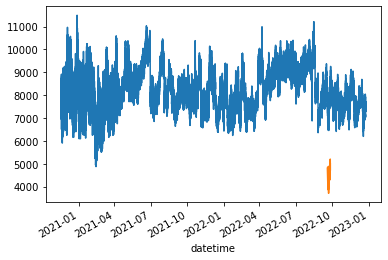

In [21]:
fig, ax = plt.subplots(1,1)
df11.cph_filtered.plot(ax=ax)
df.cph1.plot(ax=ax)
#plt.xlim(dt.datetime(2022,9,13),dt.datetime(2022,9,27))

In [22]:
df11[df.index[0]:df.index[-1]].cph_filtered.mean() / df.cph1.mean()

1.6548588493104712

In [23]:
4.754 / 1.6549

2.8726811287691096

# Sensitivity for 32

<AxesSubplot:xlabel='datetime'>

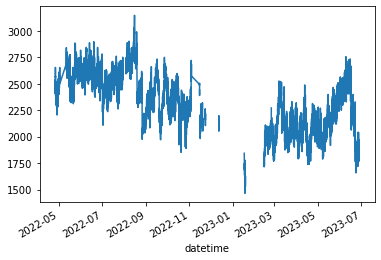

In [24]:
df32 = pd.read_csv("/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/merged/32_CRNS.txt",
                   sep="\t", comment="#")
df32["datetime"] = pd.to_datetime(df32.datetime)
df32 = df32.set_index("datetime")
df32["cph1"] = df32.counts1 / cs.conv.s_to_h(df32.nsecs1)
df32.loc[df32.cph1>4000] = np.nan
df32.loc[df32.cph1<1400] = np.nan
df32.cph1.plot()
#df32 = df32[df.index[0]:df.index[-1]]

<AxesSubplot:xlabel='datetime'>

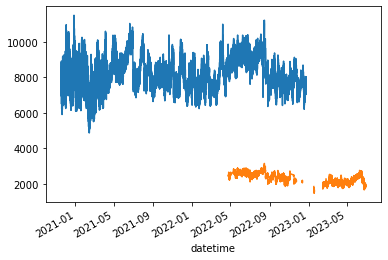

In [25]:
fig, ax = plt.subplots(1,1)
df11.cph_filtered.plot(ax=ax)
df32.cph1.plot(ax=ax)
#plt.xlim(dt.datetime(2022,9,13),dt.datetime(2022,9,27))

In [26]:
tstart, tend = "2022-09-01", "2022-09-15"
ratio_11_to_32 = df11[tstart:tend].cph_filtered.mean() / df32[tstart:tend].cph1.mean()
print(ratio_11_to_32)
print(4.754 / ratio_11_to_32)

3.341031385193691
1.4229139005003373
